# Optimal control with piecewise constant parametrization

## Setting up the electronics model

In [1]:
import numpy as np
import pytest
from copy import deepcopy
from c3.c3objs import Quantity
from c3.generator.generator import Generator
from c3.generator.devices import (
    LO,
    AWG,
    Mixer,
    DigitalToAnalog,
    VoltsToHertz,
)
from c3.signal.pulse import Envelope, Carrier
from c3.libraries.envelopes import pwc
from c3.libraries import hamiltonians
from c3.signal.gates import Instruction
from c3.model import Model
from c3.libraries import chip
from c3.parametermap import ParameterMap
from c3.experiment import Experiment

In [2]:
sim_res = 100e9  # Resolution for numerical simulation
awg_res = 2e9  # Realistic, limited resolution of an AWG

lo = LO(name="lo", resolution=sim_res, outputs=1)
awg = AWG(name="awg", resolution=awg_res, outputs=1)

dac = DigitalToAnalog(name="dac", resolution=sim_res, inputs=1, outputs=1)
mixer = Mixer(name="mixer", inputs=2, outputs=1)
v_to_hz = VoltsToHertz(
    name="v_to_hz",
    V_to_Hz=Quantity(value=1e9, min_val=0.9e9, max_val=1.1e9, unit="Hz/V"),
    inputs=1,
    outputs=1,
)

generator = Generator(
    devices={
        "LO": lo,
        "AWG": awg,
        "DigitalToAnalog": dac,
        "Mixer": mixer,
        "VoltsToHertz": v_to_hz,
    },
    chains={
        "d1": {
            "LO": [],
            "AWG": [],
            "DigitalToAnalog": ["AWG"],
            "Mixer": ["LO", "DigitalToAnalog"],
            "VoltsToHertz": ["Mixer"],
        },
    },
)

## PWC Gate Definition

In [3]:
t_final = 7e-9  # Time for single qubit gates
slices = int(t_final * awg_res)

pwc_params = {
    "inphase": Quantity(value=np.random.randn(slices), unit="V"),
    "quadrature": Quantity(value=np.random.randn(slices), unit="V"),
    "amp": Quantity(value=1.0, unit="V"),
    "xy_angle": Quantity(
        value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"
    ),
    "freq_offset": Quantity(value=0, min_val=-5 * 1e6, max_val=5 * 1e6, unit="Hz 2pi"),
}

pwc_env_single = Envelope(
    name="pwc",
    desc="piecewise constant",
    params=pwc_params,
    shape=pwc,
)

lo_freq_q1 = 5e9
carrier_parameters = {
    "freq": Quantity(value=lo_freq_q1, min_val=4.5e9, max_val=6e9, unit="Hz 2pi"),
    "framechange": Quantity(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
}
carr = Carrier(
    name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters
)

pulse_gate = Instruction(name="rx90p", t_start=0.0, t_end=t_final, channels=["d1"], targets = [0])
pulse_gate.add_component(pwc_env_single, "d1")
pulse_gate.add_component(carr, "d1")

## Setting up the Qubit model

In [4]:
q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Quantity(
        value=5e9,
        min_val=4.995e9,
        max_val=5.005e9,
        unit="Hz 2pi",
    ),
    anhar=Quantity(
        value=-150e6,
        min_val=-380e6,
        max_val=-120e6,
        unit="Hz 2pi",
    ),
    hilbert_dim=5,
)

drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive,
)
phys_components = [q1]
line_components = [drive]

model = Model(phys_components, line_components)
model.set_dressed(True)

In [5]:
parameter_map = ParameterMap(
    instructions=[pulse_gate], model=model, generator=generator
)

# ### MAKE EXPERIMENT
simulation = Experiment(pmap=parameter_map)

In [6]:
gateset_opt_map =   [
    [
      ("rx90p[0]", "d1", "pwc", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "pwc", "inphase"),
    ],
    [
      ("rx90p[0]", "d1", "pwc", "quadrature"),
  ]
]

parameter_map.set_opt_map(gateset_opt_map)

In [7]:
parameter_map.print_parameters()

rx90p[0]-d1-pwc-amp                   : 1.000 V 
rx90p[0]-d1-pwc-inphase               : 178.942 mV 910.971 mV 413.580 mV 302.991 mV -831.126 mV -305.492 mV 1.710 V -584.895 mV -1.684 V 1.837 V 981.789 mV -1.228 V -971.819 mV 933.462 mV 
rx90p[0]-d1-pwc-quadrature            : -121.327 mV -199.645 mV 202.616 mV 996.790 mV -46.131 mV -343.020 mV 551.584 mV -71.846 mV 470.491 mV -117.357 mV 591.651 mV 594.609 mV 387.548 mV -922.418 mV 



In [8]:
import os
import tempfile
from c3.optimizers.optimalcontrol import OptimalControl
from c3.libraries.fidelities import unitary_infid_set
from c3.libraries.algorithms import lbfgs

# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")

opt = OptimalControl(
    dir_path=log_dir,
    fid_func=unitary_infid_set,
    fid_subspace=["Q1"],
    pmap=parameter_map,
    algorithm=lbfgs,
    options={"maxfun" : 150},
    run_name="better_X90"
)
opt.set_exp(simulation)

## Qiskit Interface

In [9]:
from c3.qiskit import C3Provider
from c3.qiskit.c3_gates import RX90pGate, SetParamsGate
from qiskit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram

In [10]:
c3_qiskit = C3Provider()
backend = c3_qiskit.get_backend("c3_qasm_physics_simulator")
backend.set_c3_experiment(deepcopy(simulation))

In [11]:
qc = QuantumCircuit(1, 1)
qc.append(RX90pGate(), [0])
qc.draw()

┌────────────┐
  q: ┤ Rx90p(π/2) ├
     └────────────┘
c: 1/══════════════

In [12]:
job = backend.run(qc)

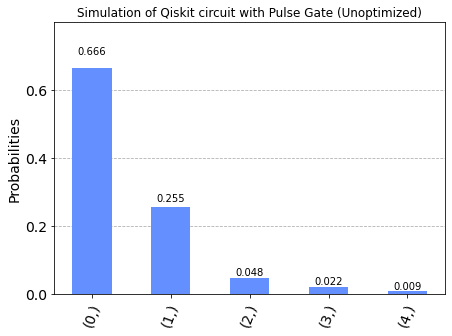

In [13]:
plot_histogram(job.result().data()['state_pops'], title='Simulation of Qiskit circuit with Pulse Gate (Unoptimized)')

## Optimal Control

In [14]:
parameter_map.get_parameters_scaled()

<tf.Tensor: shape=(29,), dtype=float64, numpy=
array([-5.55111512e-16,  4.91433795e-02,  4.27125699e-01,  1.70298546e-01,
        1.13196263e-01, -4.72404008e-01, -2.00993522e-01,  8.39778523e-01,
       -3.45262506e-01, -9.13022995e-01,  9.05158823e-01,  4.63692561e-01,
       -6.77193608e-01, -5.45050367e-01,  4.38738851e-01, -1.53691782e-01,
       -2.27887029e-01,  1.53199382e-01,  9.05568050e-01, -8.24537723e-02,
       -3.63715145e-01,  4.83797154e-01, -1.06815652e-01,  4.06973370e-01,
       -1.49930398e-01,  5.21755755e-01,  5.24557452e-01,  3.28395756e-01,
       -9.12613768e-01])>

In [15]:
opt.optimize_controls()

C3:STATUS:Saving as: /tmp/tmpdvwit0ug/c3logs/better_X90/2022_06_27_T_01_50_36/open_loop.c3log


In [16]:
opt.current_best_goal

6.51083751312953e-06

Evaluate a simple sequence to get the state populations

In [17]:
import matplotlib.pyplot as plt
def plot_controls(pmap):
    for gate, instruction in pmap.instructions.items():
        fig, axs = plt.subplots(2)
        axs[0].set_title(gate.replace("_", "-"))
        legends = [[], []]
        for chan, channel in instruction.comps.items():
            for com, component in channel.items():
                if "t_final" in component.params:
                    ts = np.linspace(0, t_final, slices)
                    shape = component.get_shape_values(ts)
                    ax = axs[0]
                    ax.plot(ts[:len(shape)]/1e-9, np.real(shape))
                    ax.plot(ts[:len(shape)]/1e-9, np.imag(shape))
                    legends[0].append((chan, com.replace("_", "-"), "I"))
                    legends[0].append((chan, com.replace("_", "-"), "Q"))
                    ax = axs[1]
                    ax.plot(ts[:len(shape)]/1e-9, np.abs(shape))
                    ax.plot(ts[:len(shape)]/1e-9, np.angle(shape))
                    legends[1].append((chan, com.replace("_", "-"), "Abs"))
                    legends[1].append((chan, com.replace("_", "-"), "Phase"))
        ax = axs[0]
        ax.legend(legends[0])
        ax = axs[1]
        ax.set_xlabel("Time [ns]")
        ax.set_ylabel("Amplitude [normalized]")
        ax.legend(legends[1])

def plot_dynamics(exp, psi_init, seq, goal=-1):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        goal: tf.float64
            Value of the goal function, if used.
        debug: boolean
            If true, return a matplotlib figure instead of saving.
        """
        model = exp.pmap.model
        exp.compute_propagators()
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        pass

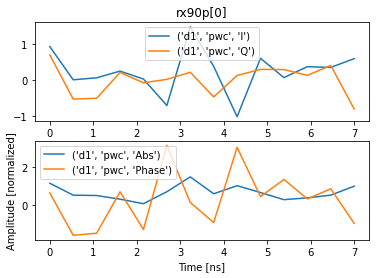

In [18]:
plot_controls(parameter_map)

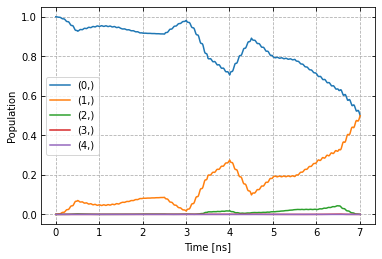

In [19]:
plot_dynamics(simulation, model.get_init_state(), ["rx90p[0]"])

## Updating the piecewise pulse description in qiskit

We now use the `SetParamsGate` to update the pwc pulse description for the previously built qiskit circuit. This `SetParamsGate` must always be added only once and only at the end of the circuit. It can be used for updating the description of as many `Instructions` (and more generally as many c3 experiment `Parameter`s) as desired through a single instance of the gate. The updated parameter values is the first element and the paramater_map for this update is the second element in the list being passed to the `params` argument of the `SetParamsGate` below. 

In [20]:
qc.append(SetParamsGate(params=[[param.asdict() for param in parameter_map.get_parameters()], 
                                gateset_opt_map]), [0])

In [21]:
job = backend.run(qc)

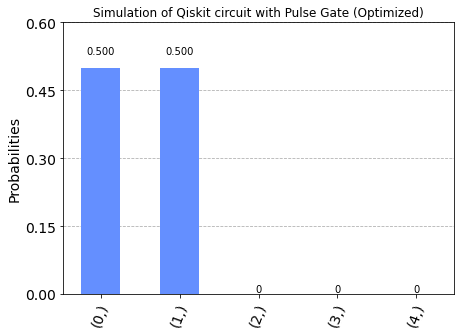

In [22]:
plot_histogram(job.result().data()['state_pops'], title='Simulation of Qiskit circuit with Pulse Gate (Optimized)')